### Imports

In [3]:
import gc
import datetime
import calendar

import numpy as np
import pandas as pd
import catboost as ctb
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from train import train

tqdm.pandas()

plt.style.use("ggplot")
sns.set_palette("tab10")
sns.set_style("darkgrid")

### Join with Stock and Sales

In [4]:
df = pd.read_parquet('true_features', engine='fastparquet')
# df['Datetime'] = df['ValidationDateTime'].dt.floor('D')

df_sales = pd.read_parquet('true_sales', engine='fastparquet')
if 'belongs' in df_sales:
    df_sales = df_sales.drop(columns='belongs')

df_stock = pd.read_parquet('true_stock', engine='fastparquet')
if 'belongs' in df_stock:
    df_stock = df_stock.drop(columns='belongs')

### УДАЛЕНИЕ PROBABILITY
df = df.drop(columns='Probability')
df['IsCorrect'] = (df['IsCorrect'] * 1).astype(float)

df = pd.merge(df, df_sales, how='left', on=['LocationId', 'ProductId', 'ValidationDateTime'])

df = pd.merge(df, df_stock, how='left', on=['LocationId', 'ProductId', 'ValidationDateTime'])

gc.collect()

# доп фичи
df['LastSale_to_Stock_location_product_1row_lag'] = df['LastSale_location_product_1row_lag_sum'] / (
        df['LastStock_location_product_1row_lag_sum'] + 1)

df['LastSale_to_Stock_location_product_7row_lag'] = df['LastSale_location_product_7row_lag_sum'] / (
        df['LastStock_location_product_7row_lag_sum'] + 1)

df['LastSale_to_Stock_location_product_14row_lag'] = df['LastSale_location_product_14row_lag_sum'] / (
        df['LastStock_location_product_14row_lag_sum'] + 1)

df['LastSale_to_Stock_location_product_30row_lag'] = df['LastSale_location_product_30row_lag_sum'] / (
        df['LastStock_location_product_30row_lag_sum'] + 1)

### Удаление лишних колонок

In [5]:
### Useless 
# (1 value only)
empty_columns = [
    'Column58', 'Column59', 'Column60', 'Column61',
    'Column62', 'Column63', 'Column64', 'Column65', 'Column67',
    'LastSale_location_product_1row_lag_std'
]

# too many nulls
null_columns = [
    'Column9', 'Column10', 'Column26', 'Column66', 'Column22',
    'IsCorrect_location_product_1row_lag_std',
    'IsCorrect_location_product_14row_lag_std',
    'IsCorrect_location_product_7row_lag_std',
    'IsCorrect_location_product_30row_lag_std',
    'IsCorrect_location_product_1row_lag_avg',
    'IsCorrect_location_product_7row_lag_avg',
    'IsCorrect_location_product_14row_lag_avg',
    'IsCorrect_location_product_30row_lag_avg',
    'IsCorrect_product_1row_lag_std',
    'IsCorrect_product_7row_lag_std',
    'IsCorrect_product_14row_lag_std',
    'IsCorrect_product_30row_lag_std',
    'IsCorrect_product_1row_lag_avg',
    'IsCorrect_product_7row_lag_avg',
    'IsCorrect_product_14row_lag_avg',
    'IsCorrect_product_30row_lag_avg',
    'LastStock',
    'LastStock_location_product_1row_lag_std',
    'LastSale',
    'LastPrice',
    'LastStock_location_product_1row_lag_sum',
    'LastStock_location_product_1row_lag_avg',
    'Column28', 'LastStock_change_location_product_1row_lag_std', 'LastPrice_change_location_product_1row_lag_std'
]

# correlation >= 0.8
corr_columns = [
    'Column30', 'Column31', 'Column32', 'Column33', 'Column25',
    'Column53', 'Column54', 'Column55', 'Column56',
    'Column57', 'Column15', 'Column7', 'Column13',
    'Column20', 'Column29', 'Column38', 'Column39',
    'IsCorrect_location_1row_lag_avg', 'IsCorrect_location_7row_lag_avg',
    'IsCorrect_location_14row_lag_avg', 'IsCorrect_product_7row_lag_avg',
    'IsCorrect_product_14row_lag_avg', 'IsCorrect_product_30row_lag_std',
    'IsCorrect_location_1row_lag_count', 'IsCorrect_location_7row_lag_count', 'IsCorrect_location_14row_lag_count',
    'IsCorrect_location_30row_lag_count', 'IsCorrect_product_7row_lag_count', 'IsCorrect_product_14row_lag_count',
    'LocationId_product_7row_lag_count_distinct', 'LocationId_product_14row_lag_count_distinct',
    'IsCorrect_location_14row_lag_std', 'LastStock_location_product_30row_lag_std',
    'LastStock_change_location_product_30row_lag_std',
    'LastPrice_location_product_1row_lag_avg', 'LastPrice_location_product_7row_lag_avg',
    'LastPrice_location_product_14row_lag_avg', 'LastSale_location_product_7row_lag_avg',
    'LastSale_location_product_14row_lag_avg', 'LastSale_location_product_30row_lag_avg',
    'LastPrice_change_location_product_14row_lag_std', 'LastStock_location_product_14row_lag_avg',
    'LastStock_location_product_30row_lag_avg', 'LastSale_location_product_7row_lag_sum',
    'LastStock_location_product_7row_lag_sum', 'LastSale_location_product_14row_lag_sum',
    'LastStock_location_product_14row_lag_sum',
    'LastStock_location_product_30row_lag_sum', 'LastSale_location_product_30row_lag_std',
    'LastSale_location_product_1row_lag_sum', 'LastSale_location_product_7row_lag_std'
]

df = df.drop(columns=empty_columns + null_columns + corr_columns)

### Null Values

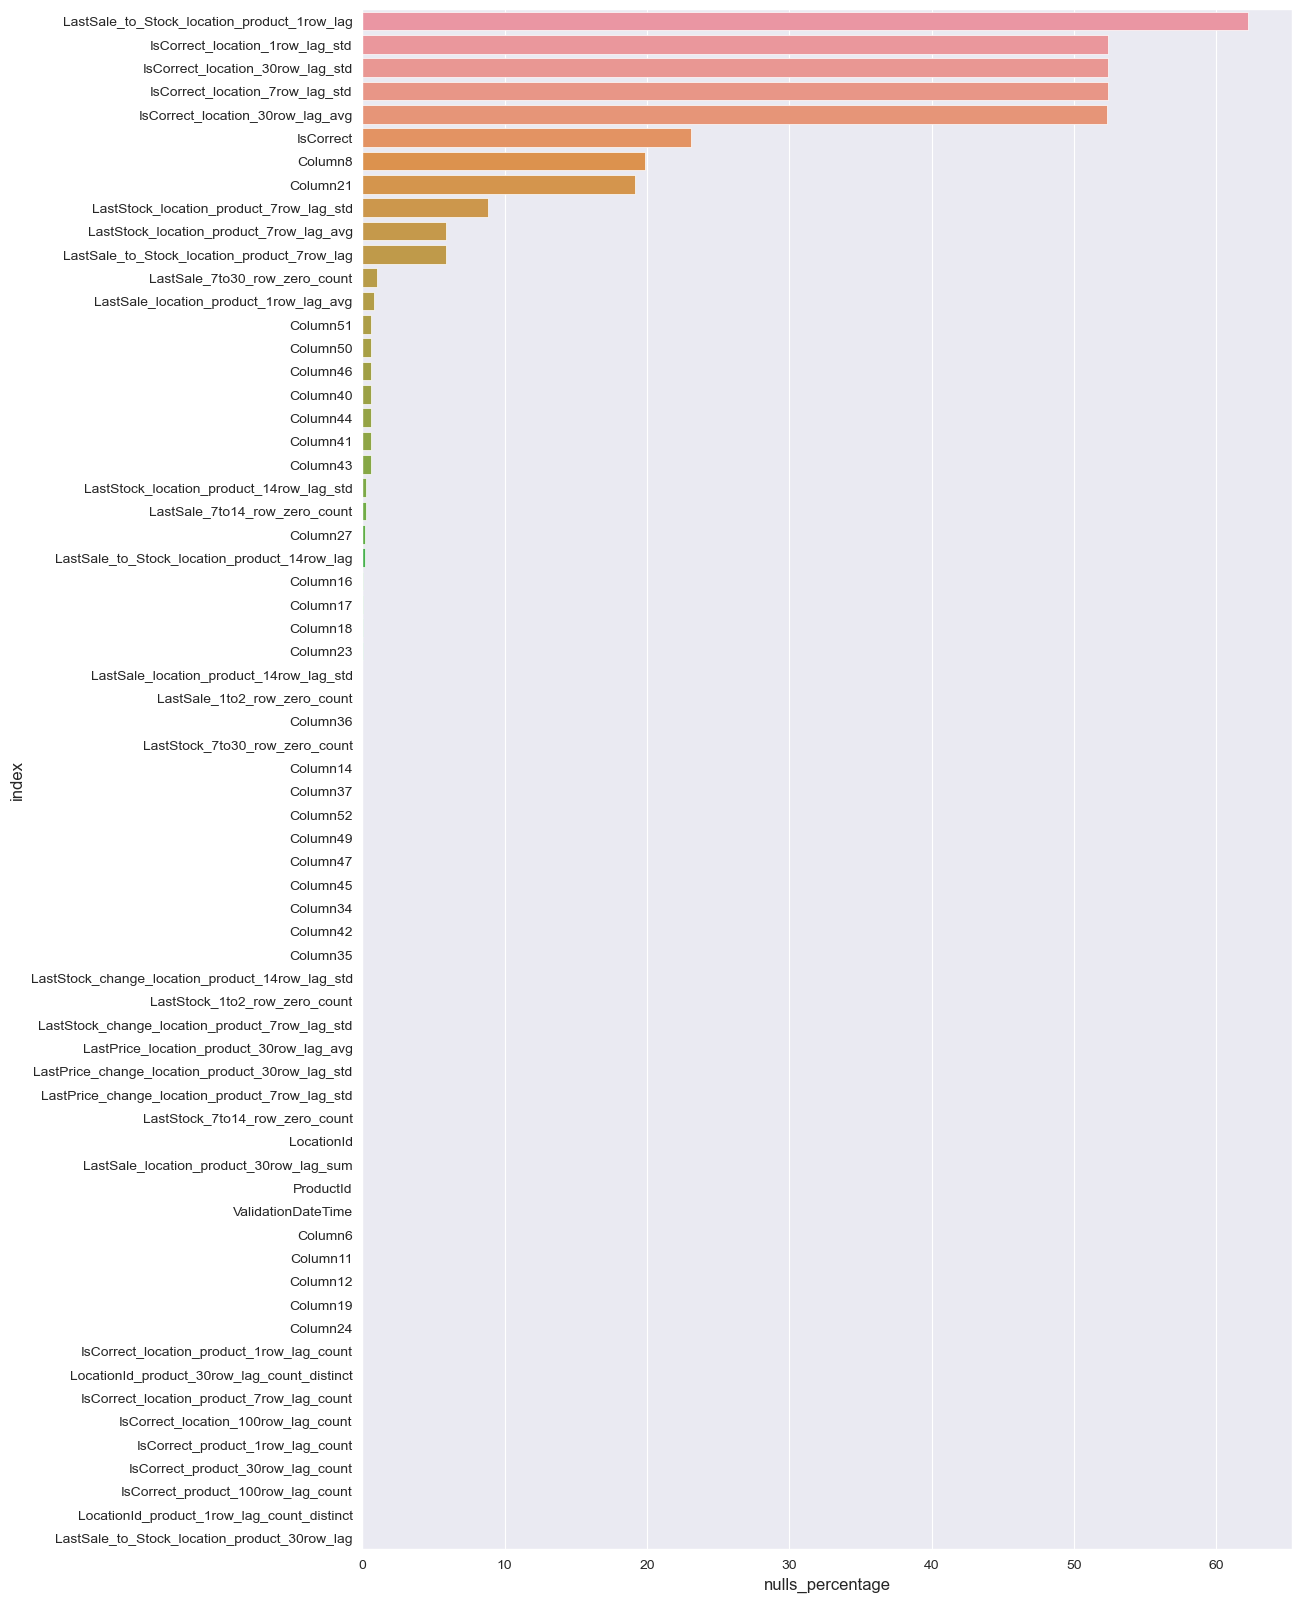

In [6]:
# totals
nulls = pd.Series(df.isna().sum(axis=0) / df.shape[0] * 100, name='nulls_percentage').reset_index()
nulls = nulls.sort_values('nulls_percentage', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 20))
sns.barplot(
    data=nulls.reset_index(),
    y='index',
    x='nulls_percentage',
    ax=ax,
    order=nulls['index']
);

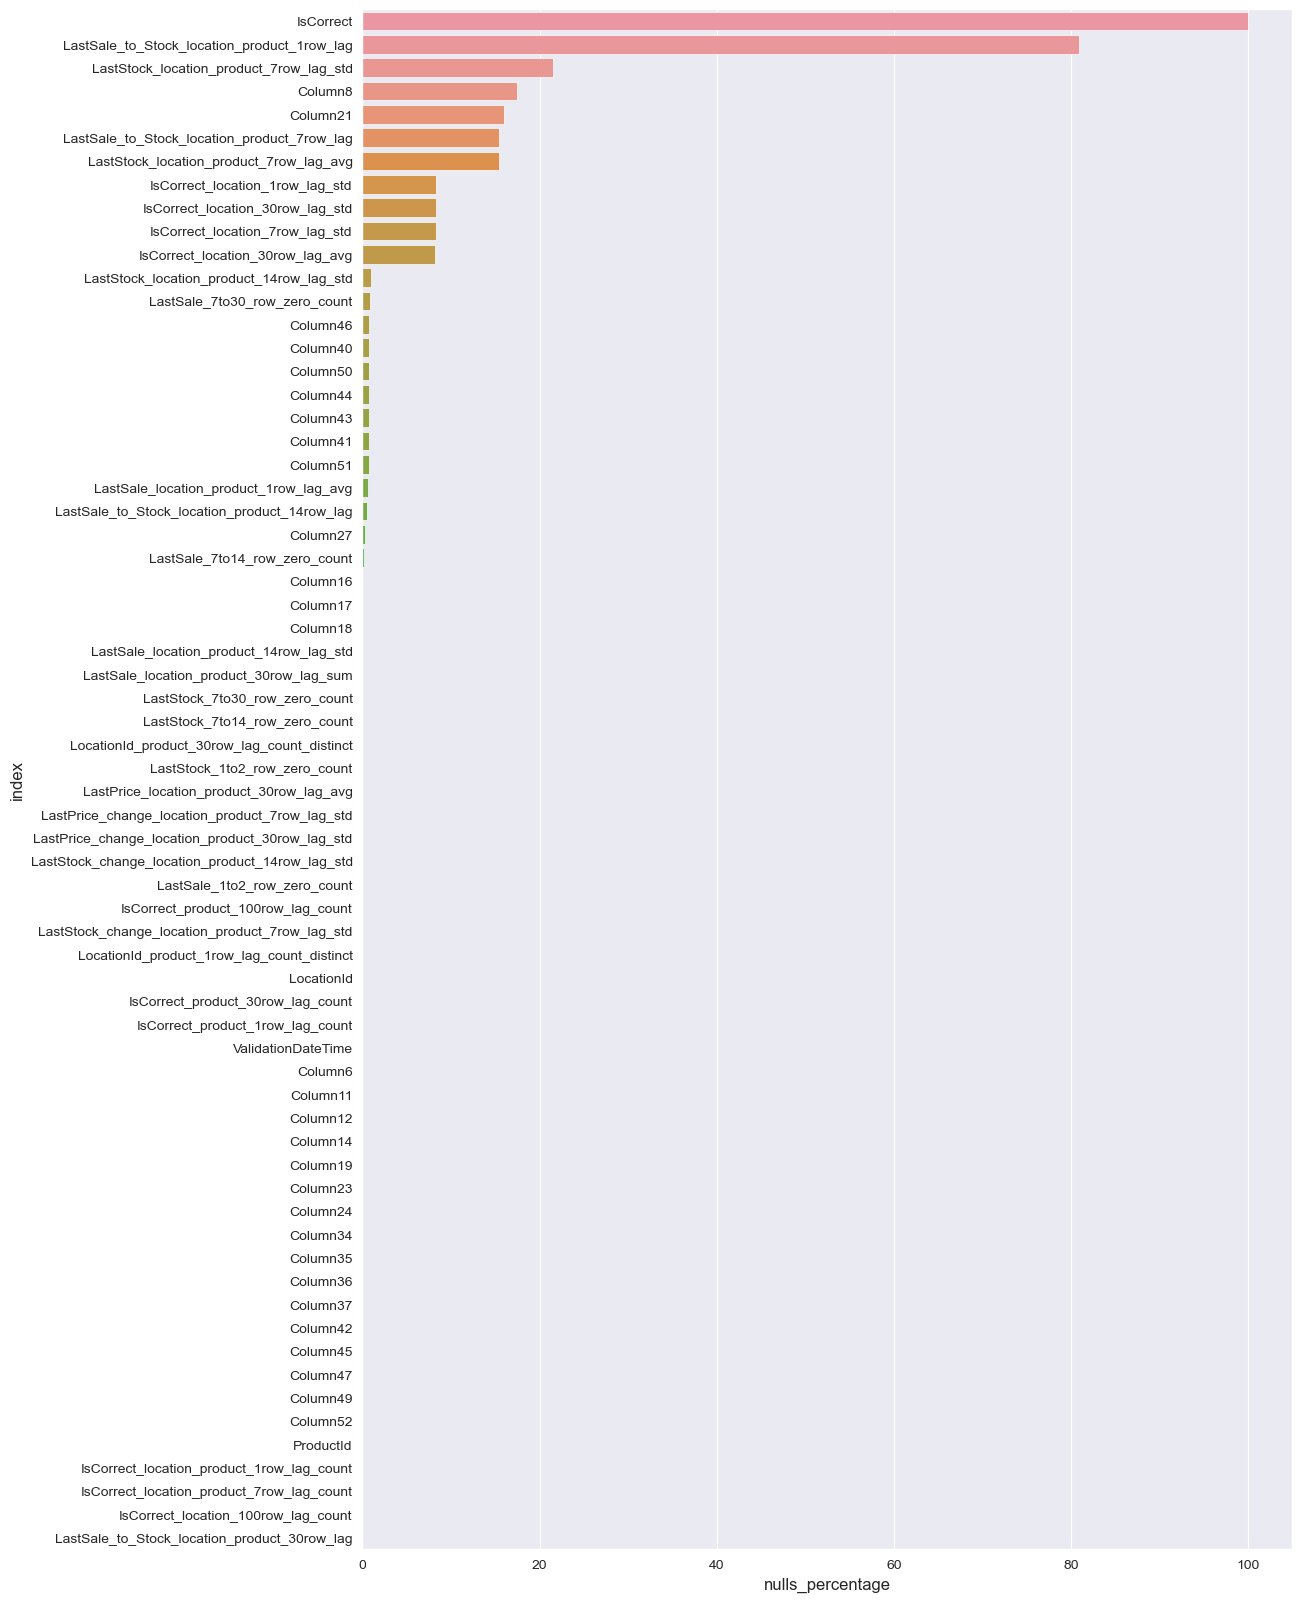

In [7]:
# test
nulls = pd.Series(
    df[df['IsCorrect'].isna()].isna().sum(axis=0) / df[df['IsCorrect'].isna()].shape[0] * 100,
    name='nulls_percentage'
).reset_index()
nulls = nulls.sort_values('nulls_percentage', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 20))
sns.barplot(
    data=nulls,
    y='index',
    x='nulls_percentage',
    ax=ax,
    order=nulls['index']
);

### Rows before current for different partitions

0it [00:00, ?it/s]

5.0
430.6800000000003
226.0


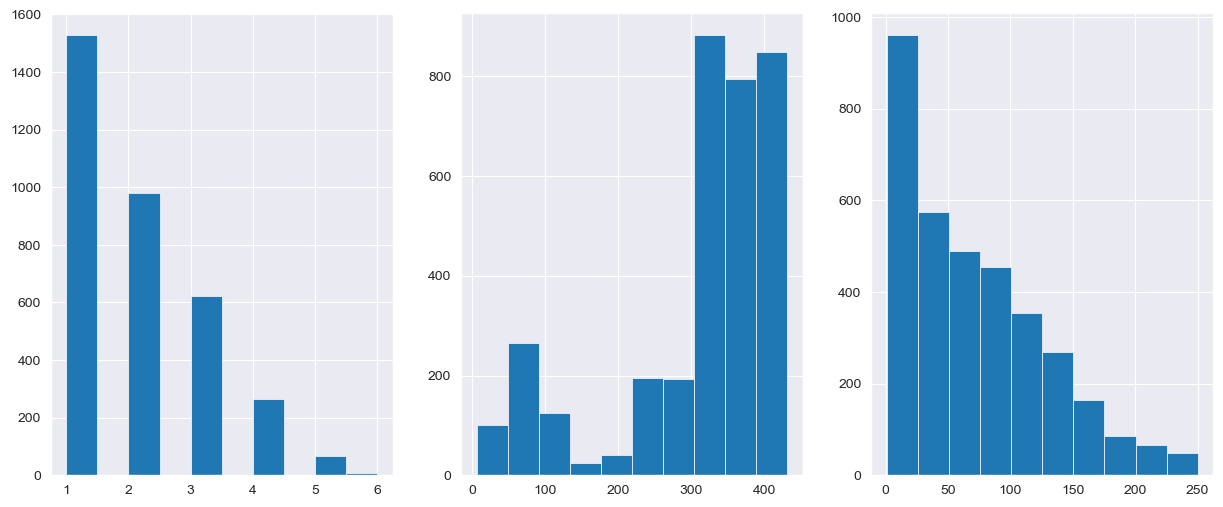

In [8]:
data = df[df['IsCorrect'].isna()]
a = []
b = []
c = []
for row in tqdm(df.loc[
                    (df['IsCorrect'].isna()) & (df['ValidationDateTime'] >= pd.to_datetime(datetime.date(2023, 8, 4))),
                    ['LocationId', 'ProductId']
                ].drop_duplicates().iterrows()):
    a.append(data[(data['LocationId'] == row[1][0]) & (data['ProductId'] == row[1][1])].shape[0])
    b.append(data[(data['LocationId'] == row[1][0])].shape[0])
    c.append(data[(data['ProductId'] == row[1][1])].shape[0])

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
print(np.quantile(a, 0.99))
ax[0].hist(a);

print(np.quantile(b, 0.99))
ax[1].hist(b);

print(np.quantile(c, 0.99))
ax[2].hist(c);

plt.show()

### Target Distribution

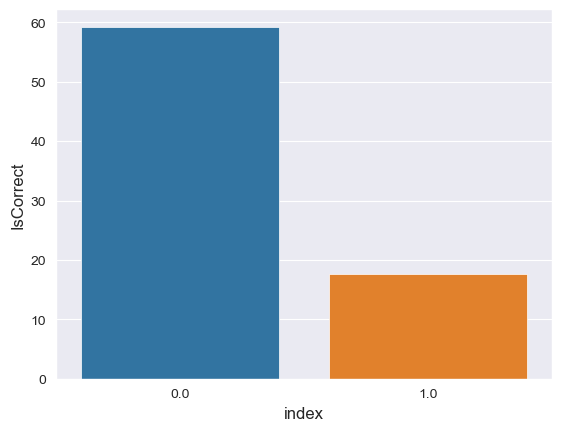

In [9]:
balance = df['IsCorrect'].value_counts().reset_index()
balance['IsCorrect'] = balance['IsCorrect'] / df.shape[0] * 100
sns.barplot(
    data=balance,
    x='index',
    y='IsCorrect'
);

### 2023-07-15 <= Validation <= 2023-07-21

In [10]:
print(pd.Series(df['ValidationDateTime'].agg(['min', 'max']), name='all'))

print('\n')

print(pd.Series(df.loc[df['IsCorrect'].notna(), 'ValidationDateTime'].agg(['min', 'max']), name='train'))

print('\n')

print(pd.Series(df.loc[df['IsCorrect'].isna(), 'ValidationDateTime'].agg(['min', 'max']), name='test'))

min   2023-06-01 14:44:35.147
max   2023-08-04 17:08:37.393
Name: all, dtype: datetime64[ns]


min   2023-06-01 14:44:35.147
max   2023-07-21 17:22:26.517
Name: train, dtype: datetime64[ns]


min   2023-07-22 14:57:43.000
max   2023-08-04 17:08:37.393
Name: test, dtype: datetime64[ns]


### Features Distribution

C:\Users\nicka\AppData\Local\Temp\ipykernel_24136\2109263257.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, bins=30);


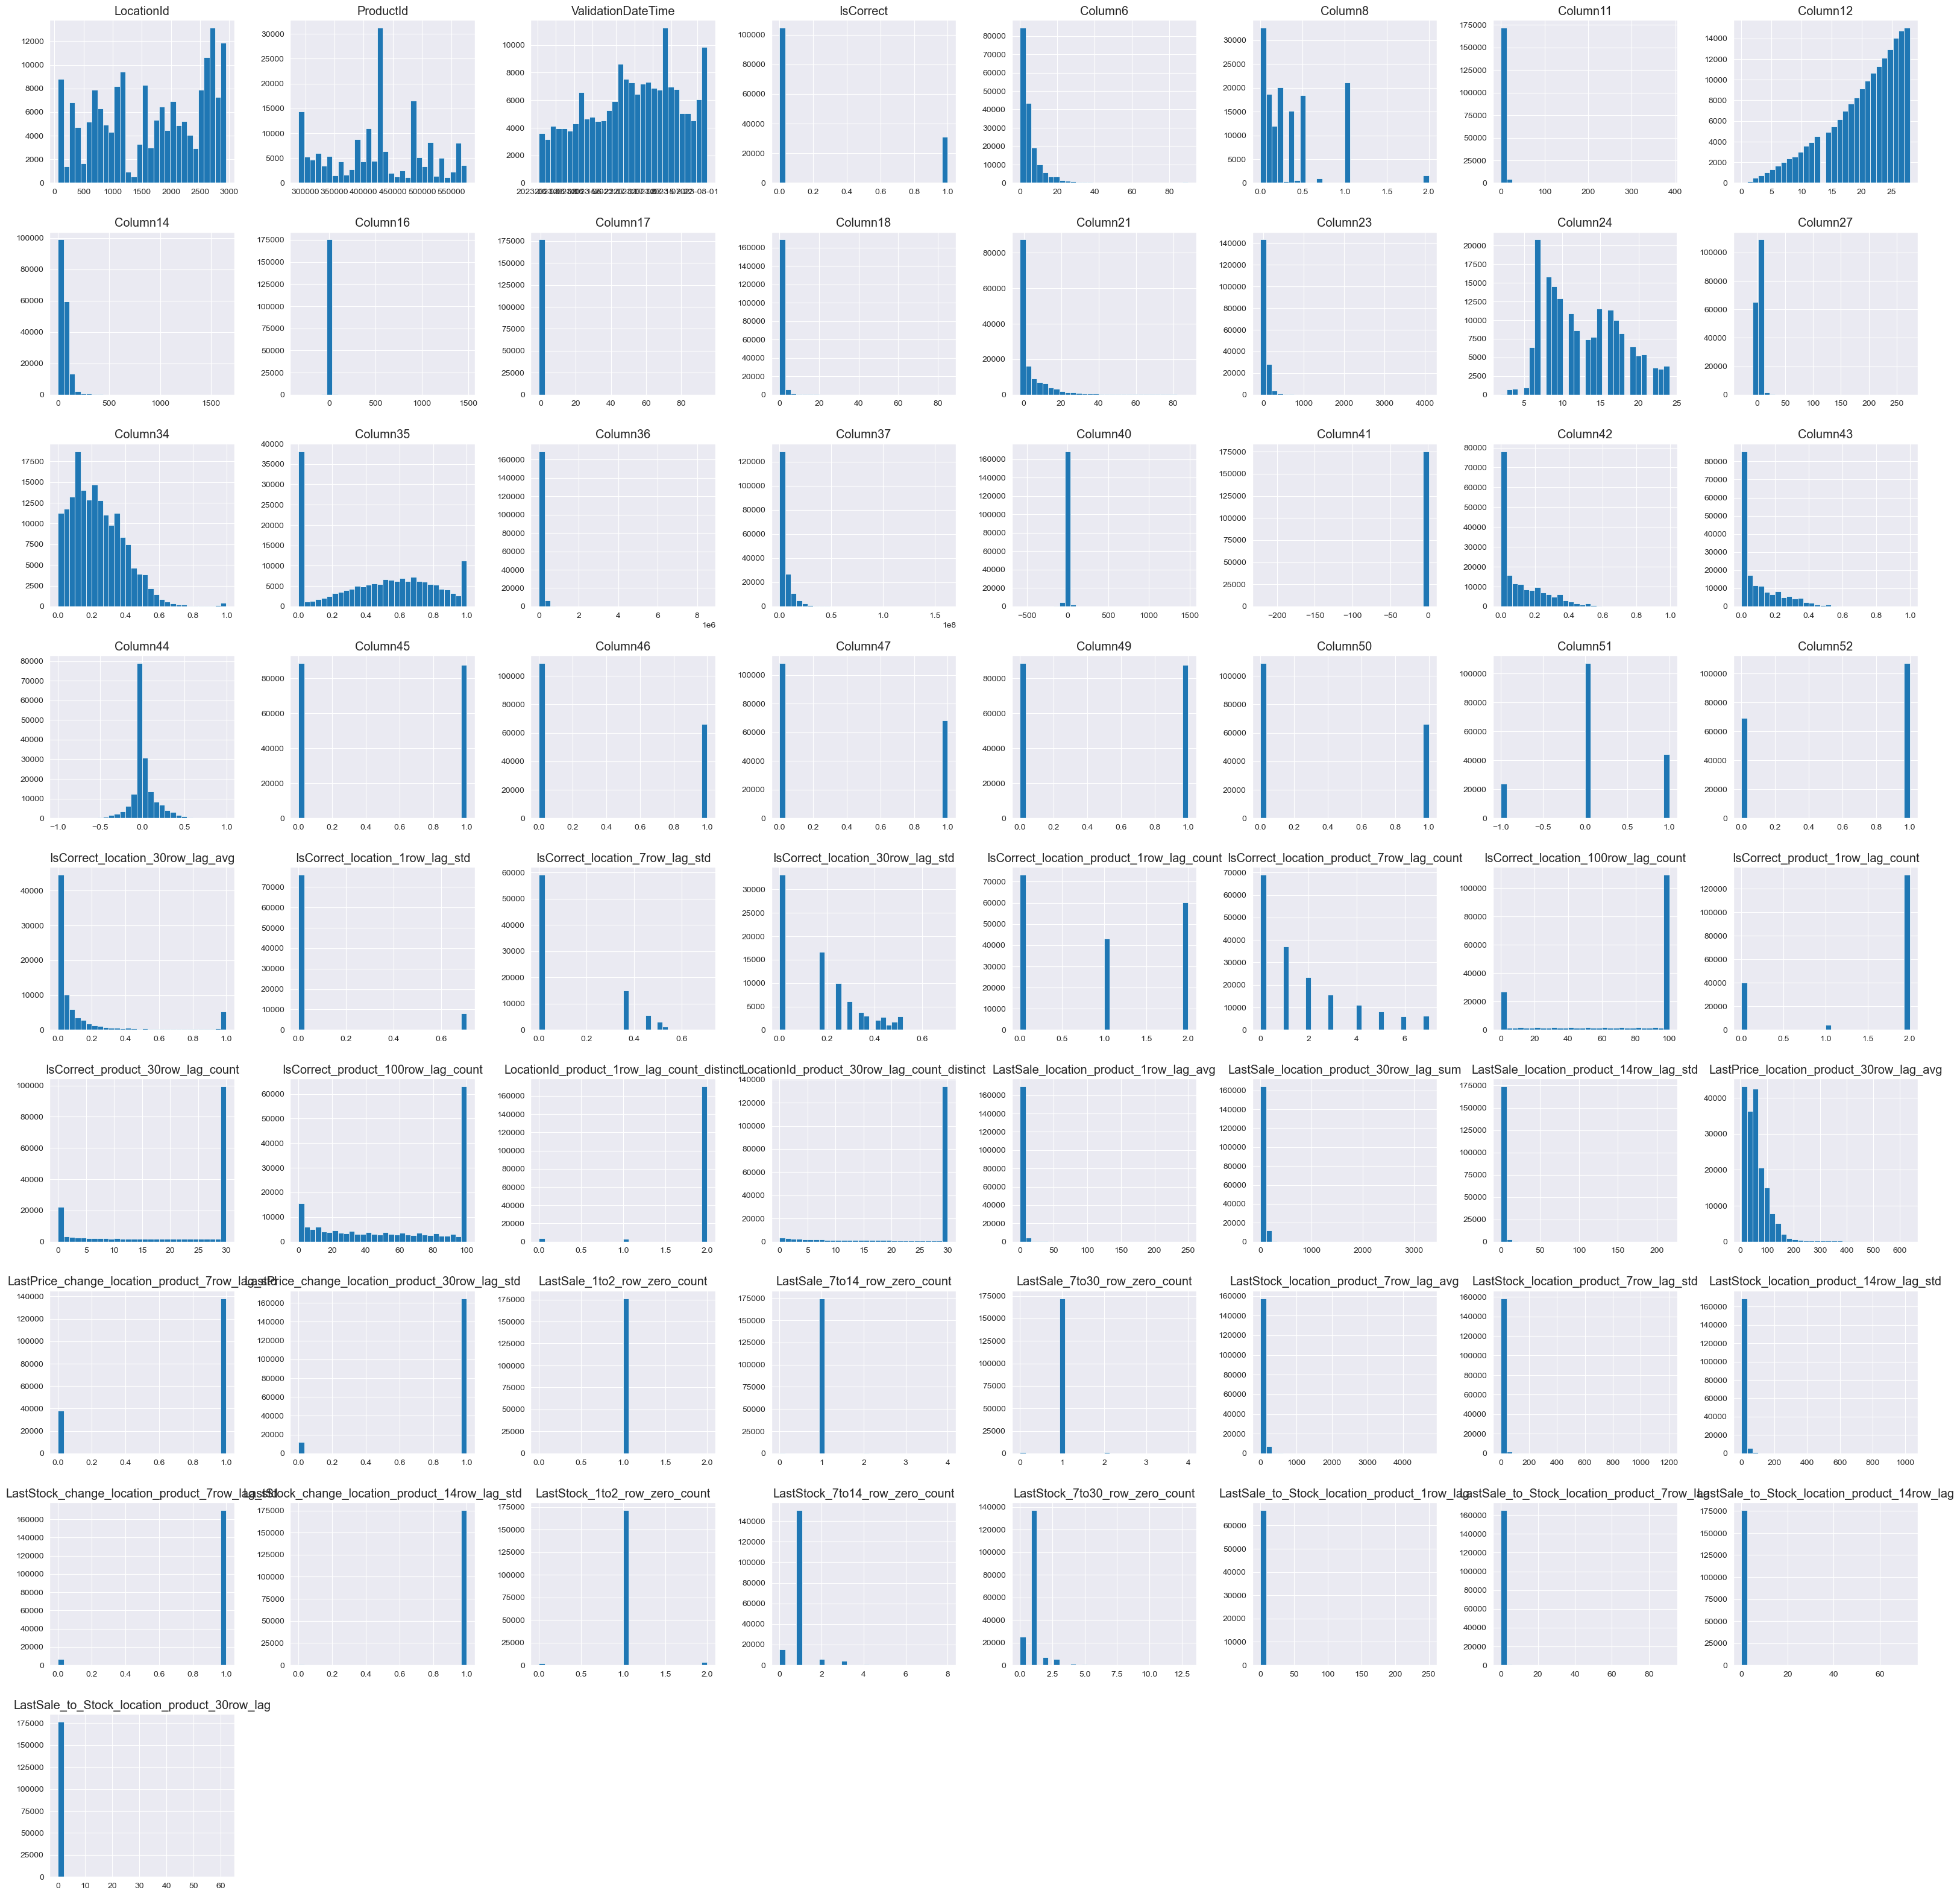

In [11]:
fig, ax = plt.subplots(figsize=(40, 40))
df.hist(ax=ax, bins=30);

### Count Uniques by Feature

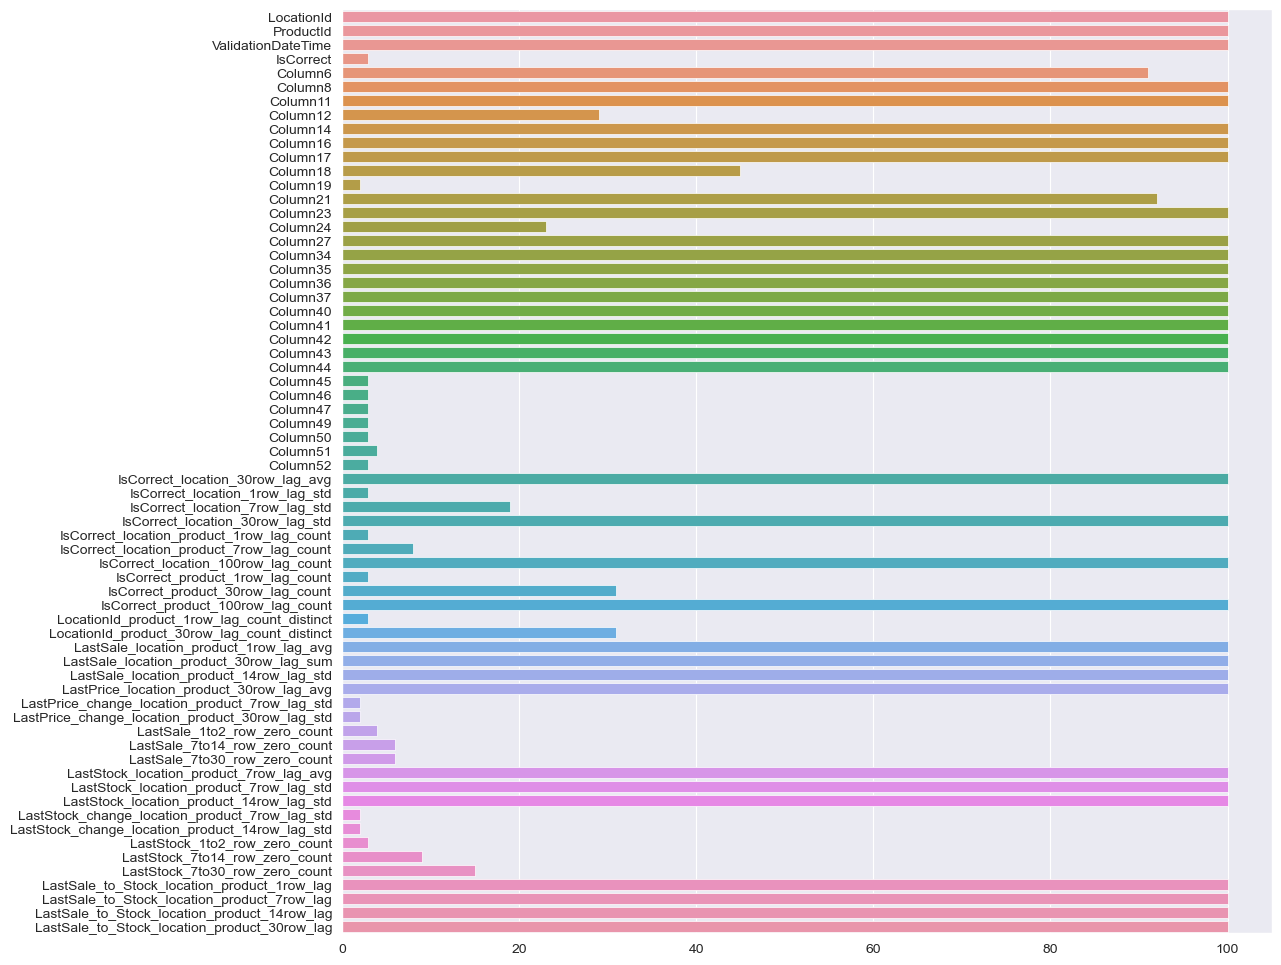

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.barplot(
    y=df.columns,
    x=[np.clip(df[col].nunique(dropna=False), None, 100) for col in df.columns],
    ax=ax
);

### Cat and Potential Cat Features

In [13]:
for col in df[[
    col
    for col in df.columns
    if (df[col].nunique(dropna=False) <= 32) & ('lag' not in col) & ('count' not in col)
]]:
    if None in df[col].unique():
        print(col, df[col].unique())
    else:
        print(col, sorted(df[col].unique()))

cat_features = [
    'LocationId', 'ProductId',
    'Column19', 'Column45', 'Column46', 'Column47', 'Column49',
    'Column50', 'Column51', 'Column52'
]
potential_cat_features = ['Column12', 'Column24']

IsCorrect [0.0, 1.0, nan]
Column12 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Column19 [False, True]
Column24 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Column45 [0.0, 1.0, nan]
Column46 [0.0, 1.0, nan]
Column47 [0.0, 1.0, nan]
Column49 [0.0, 1.0, nan]
Column50 [0.0, 1.0, nan]
Column51 [-1.0, 0.0, 1.0, nan]
Column52 [0.0, 1.0, nan]


### Sin/Cos time encodings

In [14]:
df['datetime'] = pd.to_datetime(df['ValidationDateTime'])

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_of_month_sin'] = df.progress_apply(
    lambda x: np.sin(2 * np.pi * x['day'] / calendar.monthrange(2023, x['month'])[1]),
    axis=1
)
df['day_of_month_cos'] = df.progress_apply(
    lambda x: np.cos(2 * np.pi * x['day'] / calendar.monthrange(2023, x['month'])[1]),
    axis=1
)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

df['second_sin'] = np.sin(2 * np.pi * df['second'] / 60)
df['second_cos'] = np.cos(2 * np.pi * df['second'] / 60)

  0%|          | 0/176618 [00:00<?, ?it/s]

  0%|          | 0/176618 [00:00<?, ?it/s]

In [15]:
corr_test_no_lags = df[[
    column
    for column in df.columns
    if (column not in [f'Column{i}' for i in list(range(58, 68)) + [19, 45, 46, 47]]) & ('lag' not in column) & (
            'count' not in column)
]]

corr_test_no_lags = corr_test_no_lags.drop(
    columns=['ValidationDateTime', 'datetime', 'month', 'day', 'hour', 'minute', 'second'])

corr_test_lags = df[df.columns[df.columns.str.contains('lag|count')].tolist() + ['IsCorrect']]

### Correlations

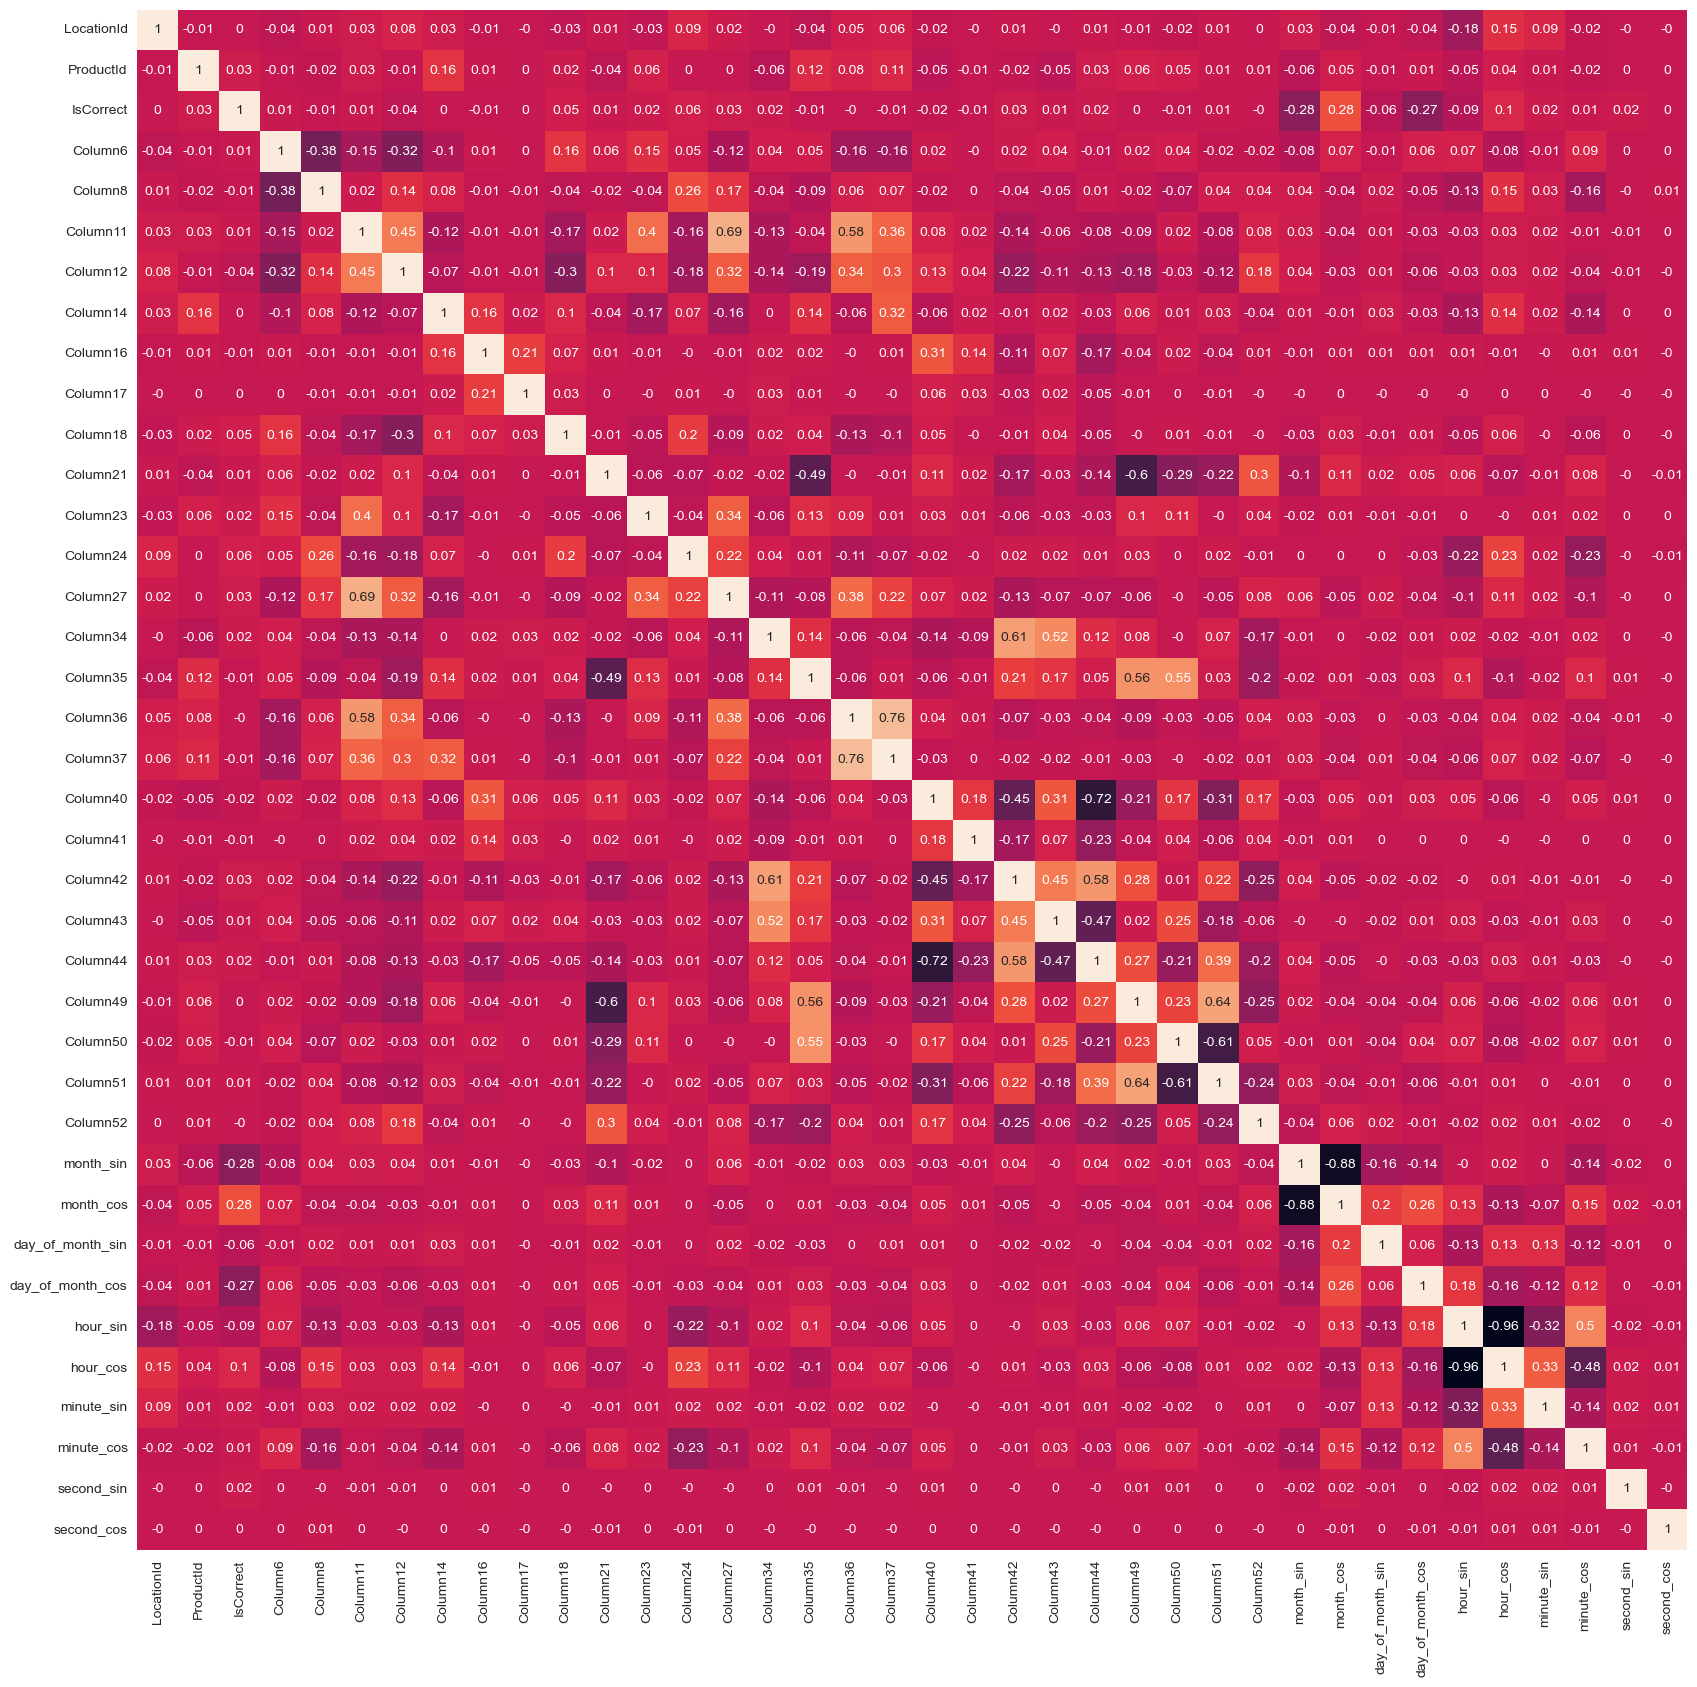

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    np.round(corr_test_no_lags.corr(), 2),
    annot=True,
    cbar=False,
    ax=ax
);

### TS Features Correlations

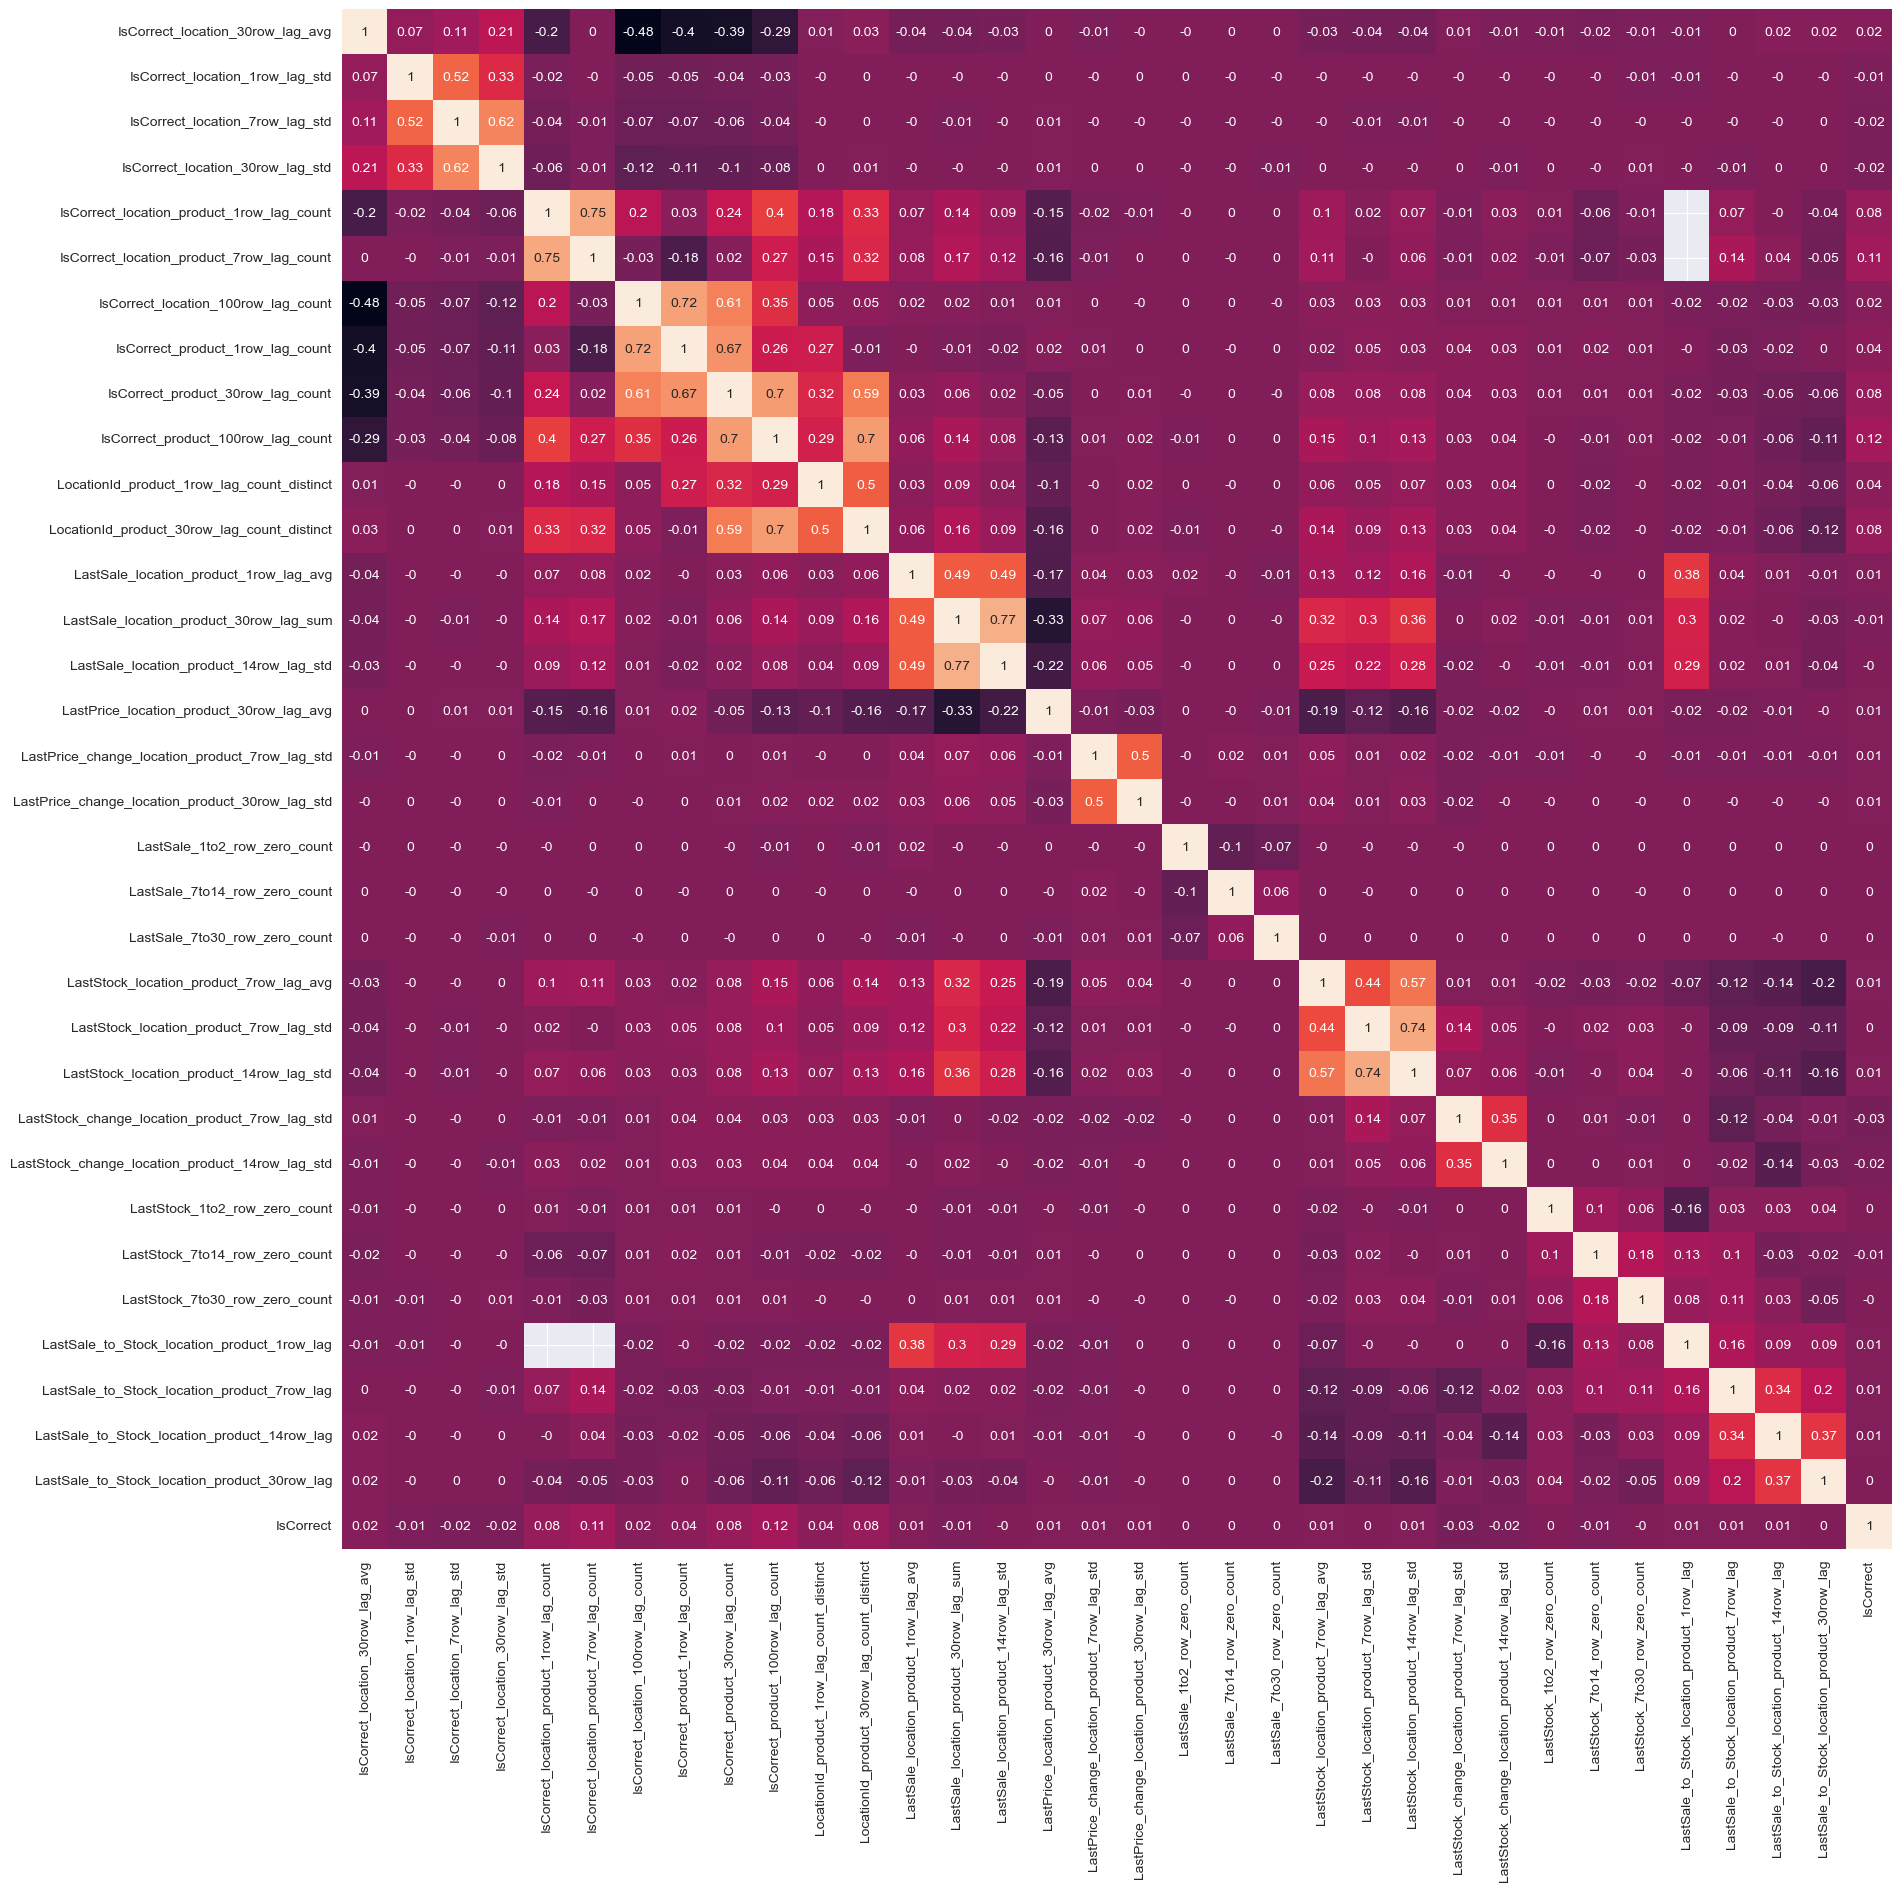

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    np.round(corr_test_lags.corr(), 2),
    annot=True,
    cbar=False,
    ax=ax
);

### Mean Proba over Time

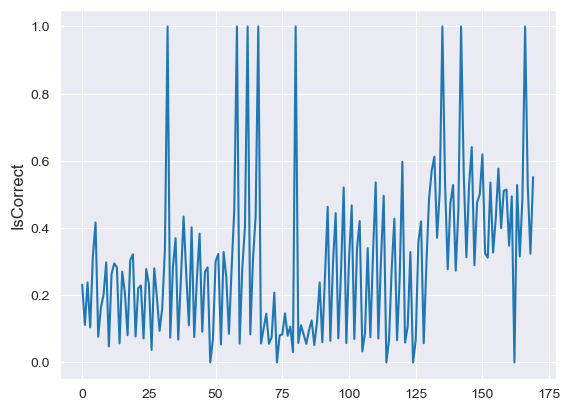

In [18]:
df['check'] = df['datetime'].dt.round('H').astype(str)
data = df.groupby('check', as_index=False)['IsCorrect'].mean()

sns.lineplot(data['IsCorrect']);

### Cross-Validation

In [19]:
# fold 0
train_start_fold0, train_end_fold0 = datetime.date(2023, 6, 1), datetime.date(2023, 6, 19)
val_start_fold0, val_end_fold0 = datetime.date(2023, 6, 20), datetime.date(2023, 6, 26)
fold0 = ((train_start_fold0, train_end_fold0), (val_start_fold0, val_end_fold0))

# fold 1
train_start_fold1, train_end_fold1 = datetime.date(2023, 6, 1), datetime.date(2023, 6, 28)
val_start_fold1, val_end_fold1 = datetime.date(2023, 6, 29), datetime.date(2023, 7, 5)
fold1 = ((train_start_fold1, train_end_fold1), (val_start_fold1, val_end_fold1))

# fold 2
train_start_fold2, train_end_fold2 = datetime.date(2023, 6, 1), datetime.date(2023, 7, 7)
val_start_fold2, val_end_fold2 = datetime.date(2023, 7, 8), datetime.date(2023, 7, 14)
fold2 = ((train_start_fold2, train_end_fold2), (val_start_fold2, val_end_fold2))

# globals
train_start_global, train_end_global = datetime.date(2023, 6, 1), datetime.date(2023, 7, 14)
val_start_global, val_end_global = datetime.date(2023, 7, 15), datetime.date(2023, 7, 21)
test_start_global, test_end_global = datetime.date(2023, 7, 22), datetime.date(2023, 8, 4)
global_fold = ((train_start_global, train_end_global), (val_start_global, val_end_global))

### Features

In [20]:
# числовые дефолтные
col_features = [
    'Column6', 'Column8', 'Column11',
    'Column16', 'Column17', 'Column18', 'Column21',
    'Column23', 'Column27',
    'Column34', 'Column35', 'Column36', 'Column37', 'Column40',
    'Column41', 'Column42', 'Column43', 'Column44',
]

# категориальные
cat_features = [
    'LocationId', 'ProductId',
    'Column19', 'Column45', 'Column46', 'Column47', 'Column49',
    'Column50', 'Column51', 'Column52'
]

# временные энкодинги
time_features = [
    'day_of_month_sin', 'day_of_month_cos',
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'
]

# потенциально категориальные
potential_cat_features = ['Column12', 'Column24']

# лаги
lag_features = [
    'IsCorrect_location_30row_lag_avg', 'IsCorrect_location_1row_lag_std',
    'IsCorrect_location_7row_lag_std', 'IsCorrect_location_30row_lag_std',
    'IsCorrect_location_product_1row_lag_count',
    'IsCorrect_location_product_7row_lag_count',
    'IsCorrect_location_100row_lag_count',
    'IsCorrect_product_1row_lag_count', 'IsCorrect_product_30row_lag_count', 'LastSale'
    # 'IsCorrect_product_100row_lag_count',
    # 'LocationId_product_1row_lag_count_distinct',
    # 'LocationId_product_30row_lag_count_distinct',
    # 'LastSale_location_product_1row_lag_avg',
    # 'LastSale_location_product_30row_lag_sum',
    # 'LastSale_location_product_14row_lag_std',
    # 'LastPrice_location_product_30row_lag_avg',
    # 'LastPrice_change_location_product_7row_lag_std',
    # 'LastPrice_change_location_product_30row_lag_std',
    # 'LastSale_1to2_row_zero_count', 'LastSale_7to14_row_zero_count',
    # 'LastSale_7to30_row_zero_count',
    # 'LastStock_location_product_7row_lag_avg',
    # 'LastStock_location_product_7row_lag_std',
    # 'LastStock_location_product_14row_lag_std',
    # 'LastStock_change_location_product_7row_lag_std',
    # 'LastStock_change_location_product_14row_lag_std',
    # 'LastStock_1to2_row_zero_count', 'LastStock_7to14_row_zero_count',
    # 'LastStock_7to30_row_zero_count',
    # 'LastSale_to_Stock_location_product_1row_lag',
    # 'LastSale_to_Stock_location_product_7row_lag',
    # 'LastSale_to_Stock_location_product_14row_lag',
    # 'LastSale_to_Stock_location_product_30row_lag'
]

target = ['IsCorrect']

In [182]:
result_metrics = {}
for fold_n, fold in tqdm(enumerate((fold0, fold1, fold2, global_fold))):
    res = train(
        fold[0][0],
        fold[0][1],
        fold[1][0],
        fold[1][1],
        df,
        col_features + time_features + potential_cat_features + lag_features,
        cat_features,
        target
    )
    result_metrics[fold_n] = res

0it [00:00, ?it/s]

Learning rate set to 0.075408
0:	learn: 0.8011588	test: 0.7232265	best: 0.7232265 (0)	total: 51.1ms	remaining: 51.1s
100:	learn: 0.8675488	test: 0.7762227	best: 0.7762464 (99)	total: 5.06s	remaining: 45s
200:	learn: 0.8886389	test: 0.7830857	best: 0.7830857 (200)	total: 10.4s	remaining: 41.2s
300:	learn: 0.9040684	test: 0.7836406	best: 0.7838396 (297)	total: 15.7s	remaining: 36.5s
400:	learn: 0.9172444	test: 0.7839164	best: 0.7845252 (356)	total: 21s	remaining: 31.4s
500:	learn: 0.9278614	test: 0.7834530	best: 0.7845252 (356)	total: 26.3s	remaining: 26.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.784525245
bestIteration = 356

Shrink model to first 357 iterations.
Learning rate set to 0.08507
0:	learn: 0.7964612	test: 0.7871833	best: 0.7871833 (0)	total: 64ms	remaining: 1m 3s
100:	learn: 0.8570163	test: 0.8225021	best: 0.8235959 (88)	total: 6.08s	remaining: 54.1s
200:	learn: 0.8764346	test: 0.8249089	best: 0.8253718 (179)	total: 12.1s	remaining: 48.1s
300:	le

  0%|          | 0/4 [00:00<?, ?it/s]

mean CV AUC: 0.72 test AUC: 0.813


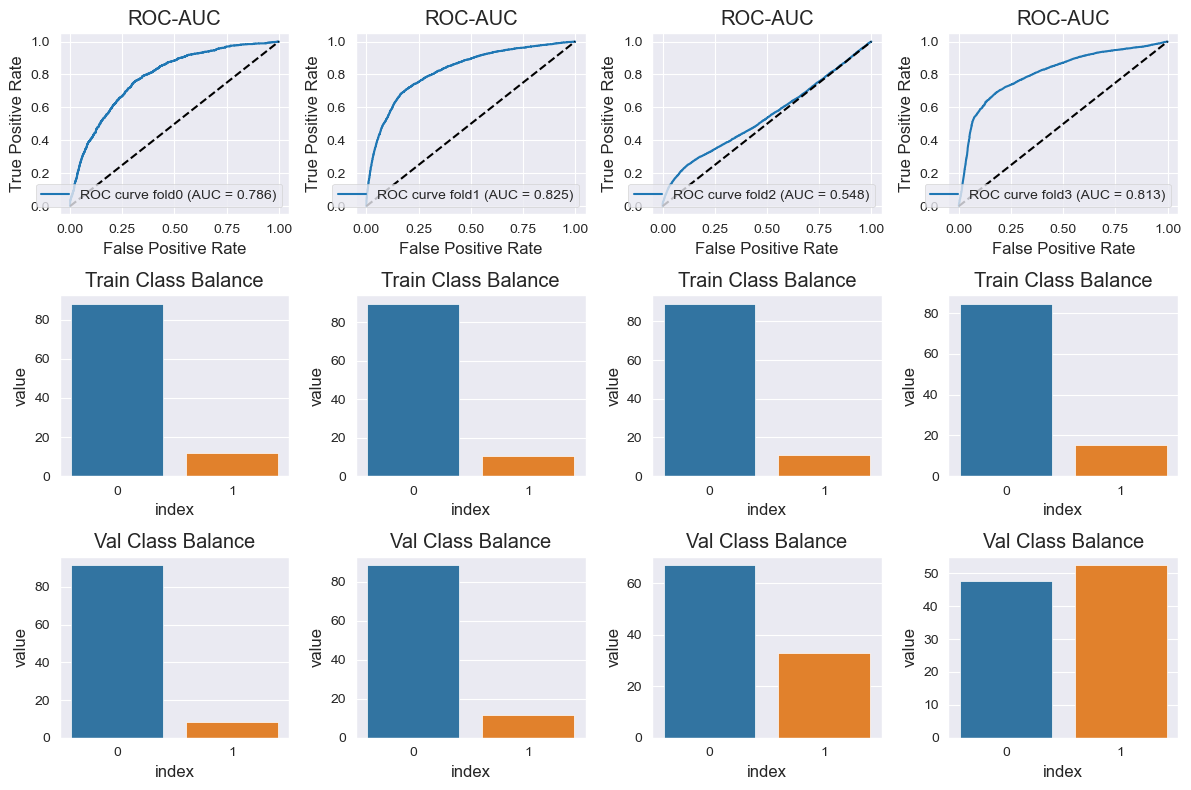

In [33]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8))

for i in tqdm(range(4)):
    fpr, tpr, label = result_metrics[i]['fpr_tpr_thresh']
    auc = result_metrics[i]['val_auc']

    # roc
    ax[0, i].plot(fpr, tpr, label=f'ROC curve fold{i} (AUC = {round(auc, 3)})')
    ax[0, i].plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax[0, i].set_xlabel('False Positive Rate')
    ax[0, i].set_ylabel('True Positive Rate')
    ax[0, i].set_title('ROC-AUC')
    ax[0, i].legend(loc='lower right')

    # train balance
    data = pd.DataFrame({'index': ['0', '1'], 'value': result_metrics[i]['train_balance']})
    data['value'] = data['value'] / data['value'].sum() * 100
    sns.barplot(x=data['index'], y=data['value'], ax=ax[1, i])
    ax[1, i].set_title('Train Class Balance')

    # val balance
    data = pd.DataFrame({'index': ['0', '1'], 'value': result_metrics[i]['val_balance']})
    data['value'] = data['value'] / data['value'].sum() * 100
    sns.barplot(x=data['index'], y=data['value'], ax=ax[2, i])
    ax[2, i].set_title('Val Class Balance')

cv_score = round(np.mean([result_metrics[i]['val_auc'] for i in range(3)]), 3)
test_score = round(result_metrics[3]['val_auc'], 3)
print(f'mean CV AUC: {cv_score}', f'test AUC: {test_score}')
plt.tight_layout()
plt.show()

### Feature Importances

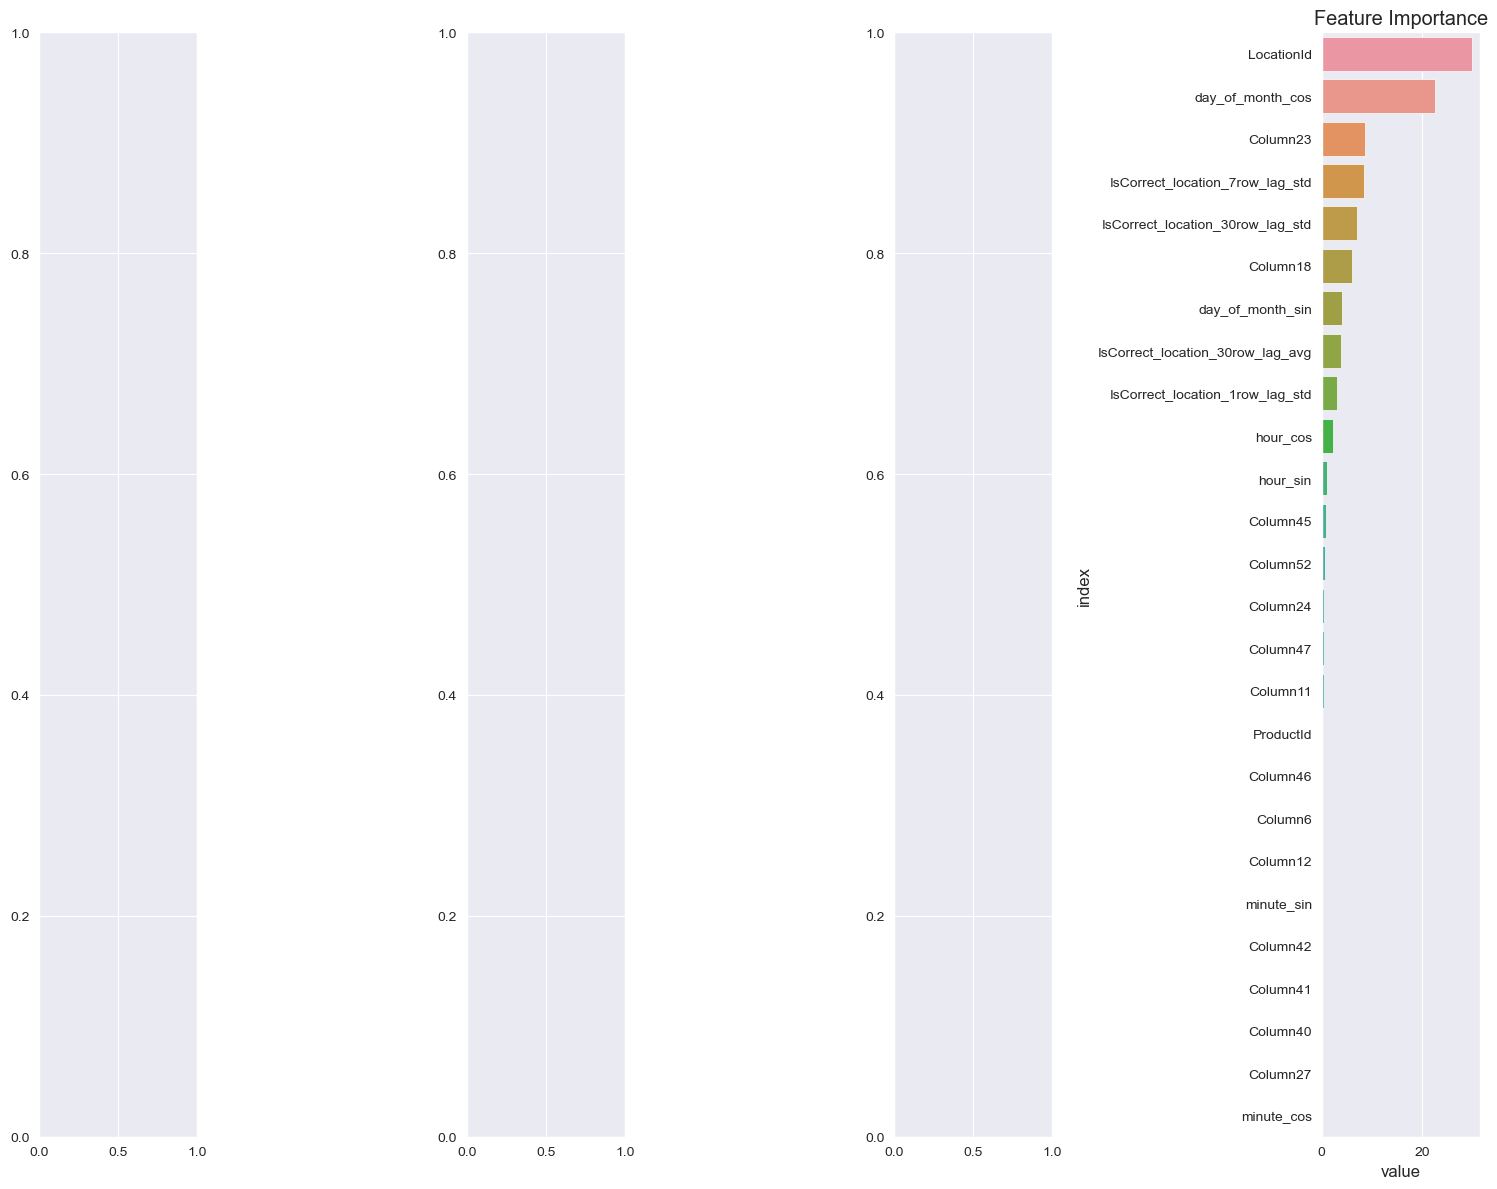

In [183]:
fig, ax = plt.subplots(1, 4, figsize=(15, 12))

for i in range(4):
    m = result_metrics[i]['model']
    data = pd.DataFrame({'index': m.feature_names_, 'value': m.feature_importances_})
    data = data.sort_values('value', ascending=False)
    sns.barplot(y=data['index'], x=data['value'], ax=ax[i])
    ax[i].set_title('Feature Importance')

plt.tight_layout()
plt.show()

### Train Full

In [23]:
num_features = col_features + time_features + potential_cat_features + lag_features
train_start, train_end = pd.to_datetime(train_start_global), pd.to_datetime(val_end_global)

X_train = df.loc[
    df['IsCorrect'].notna(),
    num_features + cat_features
]
y_train = df.loc[
    df['IsCorrect'].notna(),
    target
]
X_test = df.loc[
    df['IsCorrect'].isna(),
    num_features + cat_features + ['ValidationDateTime']
]
y_test = df.loc[
    df['IsCorrect'].isna(),
    target
]

X_train[cat_features] = X_train[cat_features].astype(str)
X_test[cat_features] = X_test[cat_features].astype(str)

model = ctb.CatBoostClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=6,
    loss_function='Logloss',
    eval_metric='AUC:hints=skip_train~false',
    cat_features=cat_features,
    verbose=100,
    random_seed=42,
    auto_class_weights='SqrtBalanced'
)

model.fit(X_train, y_train)

X_test['CalculatedProbability'] = np.clip(
    model.predict_proba(X_test[num_features + cat_features])[:, 1],
    0,
    1
)

X_test[['LocationId', 'ProductId', 'ValidationDateTime', 'CalculatedProbability']]\
    .to_csv('Dasha + 1_1.csv', sep=';', decimal='.', index=False)